In [1]:
from helpers import load_data, preprocess_data
from plots import plot_train_test_data
from helpers import split_data
from helpers import init_MF
from plots import plot_raw_data
from helpers import calculate_mse

# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse import coo_matrix, hstack

%load_ext autoreload
%autoreload 2

## Preprocessing..

In [2]:
path_dataset = "./data/de_data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


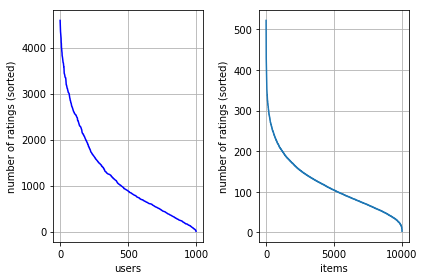

In [3]:
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

In [4]:
valid_ratings, train, test, x, x = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1059177
Total number of nonzero elements in test data:117775


In [5]:
from helpers import build_index_groups
_, nz_item_userindices, nz_user_itemindices = build_index_groups(ratings)

In [ ]:
items_per_user = []
for item, users in nz_item_userindices:
    items_per_user.append(len(users))
# the histogram of the data
n, bins, patches = plt.hist(items_per_user, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

In [ ]:
items_per_user = []
for user, items in nz_user_itemindices:
    items_per_user.append(len(items))
# the histogram of the data
n, bins, patches = plt.hist(items_per_user, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

### Baseline models

In [81]:
def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    global_mean = train[train.nonzero()].mean()
    nnz_test = test[test.nonzero()].todense() 
    mse = calculate_mse(nnz_test, global_mean)
    rmse = np.sqrt(mse / nnz_test.shape[1])
    return np.squeeze(rmse).item()
def baseline_global_median(train, test):
    """baseline method: use the global mean."""
    global_mean = np.squeeze(np.median(train[train.nonzero()].todense(), axis=1))
    nnz_test = test[test.nonzero()].todense() 
    mse = calculate_mse(nnz_test, global_mean)
    rmse = np.sqrt(mse / nnz_test.shape[1])
    return np.squeeze(rmse).item()
print("RMSE global: {}".format(baseline_global_mean(train, test)))

[[4.]]
RMSE global: 1.1292694921026554


In [10]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    _, num_users = train.shape
    for user in range(num_users):
        user_ratings_train = train[:, user]
        nnz_train = user_ratings_train[user_ratings_train.nonzero()]
        if nnz_train.shape[0] == 0:
            continue
        user_mean = nnz_train.mean()            
        user_ratings_test = test[:, user]
        nnz_test = user_ratings_test[user_ratings_test.nonzero()].todense()
        mse += calculate_mse(nnz_test, user_mean)
    return np.sqrt(1.0 * mse / test.nnz).item()
print("RMSE user-mean: {}".format(baseline_user_mean(train, test)))

RMSE user-mean: 1.0319099240955811


In [13]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    return baseline_user_mean(train.T, test.T)
print("RMSE item-mean: {}".format(baseline_item_mean(train, test)))

RMSE item-mean: 1.0959075588942098


In [13]:
num_row = nnz_elements.shape[1]
interval = int(num_row / k_fold)

In [11]:
# USER / ITEM / GLOBAL CROSSVAL

def build_indexes(data, k_fold=5):
    num_row = data.shape[1]
    interval = int(num_row / k_fold)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return k_indices

def global_cross_val(k_fold=5):
    nnz_elements = ratings[ratings.nonzero()]
    k_indices = build_indexes(nnz_elements, k_fold=5)
    res = []
    for k in range(k_fold):
        test = nnz_elements[:, k_indices[k]]
        train_idx = []
        for i in range(k_fold):
            if i == k:
                continue
                
            if len(train_idx) ==  0:
                train_idx = k_indices[i]
            else:
                train_idx = np.concatenate([train_idx, k_indices[i]])
        train = nnz_elements[:, train_idx]
        mean = baseline_global_mean(train,test)
        res.append(mean)
    print(np.sum(res)/k_fold)
    
    
def item_cross_val(k_fold=5):
    nnz_elements = ratings[ratings.nonzero()]
    k_indices = build_indexes(nnz_elements, k_fold=5)
    res = []
    for k in range(k_fold):
        test = nnz_elements[:, k_indices[k]]
        train_idx = []
        for i in range(k_fold):
            if i == k:
                continue
                
            if len(train_idx) ==  0:
                train_idx = k_indices[i]
            else:
                train_idx = np.concatenate([train_idx, k_indices[i]])
        train = nnz_elements[:, train_idx]
        mean = baseline_item_mean(train,test)
        print(mean)
        res.append(mean)
    print(np.sum(res)/k_fold)
    
def user_cross_val(k_fold=5):
    nnz_elements = ratings[ratings.nonzero()]
    k_indices = build_indexes(nnz_elements, k_fold=5)
    res = []
    for k in range(k_fold):
        test = nnz_elements[:, k_indices[k]]
        train_idx = []
        for i in range(k_fold):
            if i == k:
                continue

            if len(train_idx) ==  0:
                train_idx = k_indices[i]
            else:
                train_idx = np.concatenate([train_idx, k_indices[i]])
        train = nnz_elements[:, train_idx]
        mean = baseline_user_mean(train,test)
        print(mean)
        res.append(mean)
    print(np.sum(res)/k_fold)
    
    
    
item_cross_val()
     


1.118953132828715
1.1202690744172918


KeyboardInterrupt: 

#### Baseline estimate model

In [104]:
def compute_error_baseline_estimate(data, 
                                    nz, 
                                    user_bias, 
                                    item_bias, 
                                    global_bias,
                                    lambda_user_bias,
                                    lambda_item_bias):
    mse = 0
    for item, user in nz:
        prediction = global_bias + item_bias[item] + user_bias[user]
        mse += (data[item, user] - prediction) ** 2
    reg = lambda_user_bias * user_bias.T.dot(user_bias) + lambda_item_bias * item_bias.T.dot(item_bias)
    mse += reg
    return np.sqrt(mse / len(nz))


# See 2.1 http://www.cs.rochester.edu/twiki/pub/Main/HarpSeminar/Factorization_Meets_the_Neighborhood-_a_Multifaceted_Collaborative_Filtering_Model.pdf
def baseline_estimate(train,
                      test,
                      gamma=0.02, 
                      num_features=20,
                      lambda_user_bias=0.1,
                      lambda_item_bias=0.1,
                      num_epochs=10):
    
    global_bias = train[train.nonzero()].mean()
    
    # He init
    user_bias = np.random.normal(scale=np.sqrt(2/num_features), size=train.shape[1])
    item_bias = np.random.normal(scale=np.sqrt(2/num_features), size=train.shape[0])
    
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("Starting SGD...")
    for it in range(num_epochs):
        np.random.shuffle(nz_train)
        gamma /= 1.2
        for d, n in nz_train:
            prediction = global_bias + user_bias[n] + item_bias[d]
            error = train[d, n] - prediction
            # Update variables
            user_bias[n] +=  gamma * (error - lambda_user_bias * user_bias[n])
            item_bias[d] +=  gamma * (error - lambda_item_bias * item_bias[d])
        rmse = compute_error_baseline_estimate(train, 
                                               nz_train, 
                                               user_bias, 
                                               item_bias, 
                                               global_bias,
                                               lambda_user_bias,
                                               lambda_item_bias)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
    rmse = compute_error_baseline_estimate(test, 
                                           nz_test, 
                                           user_bias, 
                                           item_bias,
                                           global_bias,
                                           lambda_user_bias,
                                           lambda_item_bias)
    print("RMSE on test data: {}.".format(rmse))
    
    return user_bias, item_bias, global_bias 

user_bias, item_bias, global_bias = baseline_estimate(train, test)

Starting SGD...
iter: 0, RMSE on training set: 0.9994629076738408.
iter: 1, RMSE on training set: 0.9956075486578966.
iter: 2, RMSE on training set: 0.99370587331951.
iter: 3, RMSE on training set: 0.9930551822462327.
iter: 4, RMSE on training set: 0.9924684505310238.
iter: 5, RMSE on training set: 0.9920580299985728.
iter: 6, RMSE on training set: 0.9915115565597591.
iter: 7, RMSE on training set: 0.9913468214722916.
iter: 8, RMSE on training set: 0.9911768392951089.
iter: 9, RMSE on training set: 0.9910120783857594.
RMSE on test data: 1.001507976095007.


In [106]:
from helpers import create_submission_baseline_estimate
create_submission_baseline_estimate(user_bias, item_bias, global_bias)

## KNN

In [309]:
from helpers import build_index_groups

nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)

num_items, num_users = train.shape
for user, items in nz_user_itemindices:
    user_means[user] = train[items, user].mean()

In [352]:
# Takes ~10 min to compute!
def construct_similarity_matrix(data, nz_user_userindices):
    num_items, num_users = data.shape
    print("Constructing sim matrix")
    similarity_matrix = np.zeros((num_users, num_users))
    for i, items_i in nz_user_itemindices:
        print(i)
        for j, items_j in nz_user_itemindices:
            if i == j:
                continue
                            
            item_intersection = np.intersect1d(items_i, items_j)
            
            if len(item_intersection) == 0:
                continue
            
            # Calculate pearson coefficient, could might as well have used np.corrcoef
            # but calculatig it yourself is so much more fun!
            
            r_i = data[item_intersection, i].todense()
            r_i = r_i -  r_i.mean()
            r_j = data[item_intersection, j].todense()
            r_j = r_j -  r_j.mean()
     
            numerator = r_i.T @ r_j

            denominator = np.sqrt(r_i.T.dot(r_i)) * np.sqrt(r_j.T.dot(r_j))
            similarity_matrix[i, j] = numerator / denominator if denominator > 0 else 0       
            
    return similarity_matrix

In [353]:
def construct_s_matrix(train, nz_train, user_means):
    s_matrix = sp.lil_matrix(train.shape)
    #nz_row, nz_col = train.nonzero()
    #nz_train = list(zip(nz_row, nz_col))
    print("Constructing S matrix...")
    for d, n in nz_train:
        s_matrix[d, n] = train[d, n] - user_means[n]
    return s_matrix

In [354]:
def evaluate_knn(similarity_matrix, s_matrix, test, k, nz_item_userindices, similarity_treshold=0.1):
    mse = 0
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    iters = 0
    print("Starting evaluation..")
    for d, n in nz_test:
        iters += 1
        if iters % 10000 == 0:
            print(iters)
            
        # Get index of k most similar users
        # Set all similarityis not in d_users to zero -> argsort -> take top k.
        _, d_users = nz_item_userindices[d]
        d_users_similarity = similarity_matrix[n, :].copy()
        kn_index = np.zeros(similarity_matrix.shape[1])
        kn_index[d_users] = similarity_matrix[n, d_users]
        kn_index = kn_index.argsort()[-k:][::-1]

        kn_similarity = kn_similarity[n, kn_index] 
        
        kn_mean_centered_rating = s_matrix[d, kn_index].todense()
        kn_mean_centered_rating = np.squeeze(np.asarray(kn_mean_centered_rating))
        
        # Remove users with low similarity as described, heuristic desribed in 2.3.1
        kn_mean_centered_rating = kn_mean_centered_rating[kn_similarity > similarity_treshold]
        kn_similarity = kn_similarity[kn_similarity > similarity_treshold]

        # Compute prediction
        numerator = kn_mean_centered_rating.dot(kn_similarity)
        denominator = np.sum(np.abs(similarity_matrix[n, kn_index]))
        
        prediction = numerator / denominator
    
        user_mean = user_means[n]
        prediction = user_mean + prediction
        
        # Compute error
        mse += (test[d, n] - prediction) ** 2
        
    return np.sqrt(mse / len(nz_test))

In [ ]:
similarity_matrix = construct_similarity_matrix(train, nz_user_itemindices)

In [ ]:
# user-specific KNN
def KNN(similarity_matrix, train, test, k, nz_train, nz_item_userindices, nz_user_itemindices, user_means):
    #nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)
    #similarity_matrix = construct_similarity_matrix(train, nz_user_itemindices)
    s_matrix = construct_s_matrix(train, nz_train, user_means)
    print(evaluate_knn(similarity_matrix, s_matrix, test, k, nz_item_userindices))
    
KNN(similarity_matrix,  train, test, 40, nz_train, nz_item_userindices, nz_user_itemindices, user_means)

In [319]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(n_neighbors=25, metric='correlation')
model.fit(train.todense())
distances, indices = model.kneighbors(test.todense())

In [321]:
print(distances[0])
print(indices[0])
#print(distances.shape)
#print(indices.shape)

#for d, n in nz_test[:20000]:
#    k_near = distances[n]
#    
#    numerator = np.sum(sim * s)
#    denominator = np.sum(np.abs(similarity_matrix[n, k_similar_index]))


[0.71805531 0.72333828 0.72889909 0.73265069 0.74629688 0.76158883
 0.7670455  0.7752808  0.77637654 0.78435691 0.79026452 0.79066985
 0.79232536 0.79292786 0.79354054 0.79468498 0.80946411 0.81175635
 0.81250677 0.81265502 0.81674545 0.81690947 0.81691794 0.81733007
 0.81753813]
[6494 4381 4031 2692 5496 4681 4714 1793 6651  833 9760 6695 9594 7485
 1324 3891 9864 6192 6124 2376 2843 5027 7361  510 9852]


## A NEIGHBORHOOD MODEL
http://www.cs.rochester.edu/twiki/pub/Main/HarpSeminar/Factorization_Meets_the_Neighborhood-_a_Multifaceted_Collaborative_Filtering_Model.pdf

probably too computationally heavy

In [395]:
def compute_error_neighborhood(data, user_features, item_features, nz):
    mse = 0   
    for row, col in nz:
        p = user_features[:, col]
        q = item_features[:, row]
        prediction = p.T.dot(q)
        mse += (data[row, col] - prediction)**2
    return np.sqrt(1.0 * mse / len(nz))

def neighborhood_model(train, 
                             test, 
                             num_features=20, 
                             gamma=0.05, 
                             lambda_user_bias=0.1, 
                             lambda_item_bias=0.1,
                             lambda_w=0.1,
                             lambda_c=0.1,
                             num_epochs=10):     
    """matrix factorization by SGD."""

    # set seed
    np.random.seed(988)
    
    
    global_mean = train[train.nonzero()].mean()
    user_bias = np.random.normal(scale=np.sqrt(2/num_features), size=train.shape[1])
    item_bias = np.random.normal(scale=np.sqrt(2/num_features), size=train.shape[0])
    w = np.random.normal(scale=np.sqrt(2/num_features), size=train.shape)
    c = np.random.normal(scale=np.sqrt(2/num_features), size=train.shape)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)


    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2

        iters = 0
        for d, n in nz_train:
            iters += 1
            if iters % 10000 == 1:
                print(iters)
            
            user, items = nz_user_itemindices[n]
            items = items[: 500]
            """"
            ws = 0
            cs = 0
            for item in items:
                if item == d:
                    continue
                b = global_mean + item_bias[item] + user_bias[n]
                ws += (train[item, n] - b) * w[item, n]
                cs += c[item, n]
            """
                
            b = global_mean + item_bias[items] + user_bias[n]

            ws = (np.squeeze(np.asarray(train[items, n].todense())) - b) @ w[items, n]
            cs = np.sum(c[items, n])
            lSqrt = np.sqrt(len(items))

            base_prediction = global_mean + item_bias[d] + user_bias[n]
            prediction = base_prediction + ws/lSqrt + cs/lSqrt
            error = train[d, n] - prediction

                        
            # Update variables
            user_bias[n] +=  gamma * (error - lambda_user_bias * user_bias[n])
            item_bias[d] +=  gamma * (error - lambda_item_bias * item_bias[d])
            
            bs = global_mean + item_bias[items] + user_bias[n]         
            t_items = np.squeeze(np.asarray(train[items,n].todense()))
            w[items, n] += gamma * ((1/lSqrt) * error * (t_items - bs) - lambda_w * w[items, n])
            c[items, n] += gamma * ((1/lSqrt) * error  - lambda_c * c[items, n])
            

     
        rmse = compute_error_neighborhood(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse)) 
        rmse = compute_error_neighborhood(test, user_features, item_features, nz_test)
        print("RMSE on test data: {}.".format(rmse))
    return item_features, user_features
        
item_features, user_features = neighborhood_model(train, 
                                                           test, 
                                                           gamma=0.013, 
                                                           num_epochs=5,
                                                           num_features=20)

learn the matrix factorization using SGD...
1
10001
20001
30001
40001
50001
60001


KeyboardInterrupt: 

## Matrix factorization baseline latent factors

In [400]:
def compute_error_v1(data, user_features, item_features, nz):
    mse = 0   
    for row, col in nz:
        p = user_features[:, col]
        q = item_features[:, row]
        prediction = p.T.dot(q)
        mse += (data[row, col] - prediction)**2
    return np.sqrt(1.0 * mse / len(nz))

def matrix_factorization_SGD_v1(train, 
                             test, 
                             num_features=20, 
                             gamma=0.05, 
                             lambda_user=0.1, 
                             lambda_item=0.7, 
                             num_epochs=10):     
    """matrix factorization by SGD."""

    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2

        for d, n in nz_train:

            q = item_features[:, d]
            p = user_features[:, n]
            prediction = p.T.dot(q)  
            
            error = train[d, n] - prediction
            
            # Update variables
            item_features[:, d] += gamma * (error * p - lambda_item * q)
            user_features[:, n] += gamma * (error * q - lambda_user * p)
     
        rmse = compute_error_v1(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse)) 
        rmse = compute_error_v1(test, user_features, item_features, nz_test)
        print("RMSE on test data: {}.".format(rmse))
    return item_features, user_features
        
item_features, user_features = matrix_factorization_SGD_baseline(train, 
                                                           test, 
                                                           gamma=0.01, 
                                                           lambda_user=0.1,
                                                           lambda_item=0.5,
                                                           num_epochs=10,
                                                           num_features=17)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0451849800830444.
RMSE on test data: 1.0639182121388713.
iter: 1, RMSE on training set: 1.0270426884752444.
RMSE on test data: 1.0413497456278764.
iter: 2, RMSE on training set: 1.0211761519110731.
RMSE on test data: 1.0352123176231065.
iter: 3, RMSE on training set: 1.0208435592623124.
RMSE on test data: 1.034188081195767.
iter: 4, RMSE on training set: 1.0187363115686565.
RMSE on test data: 1.0316211853573893.
iter: 5, RMSE on training set: 1.0165396836040579.
RMSE on test data: 1.028323744336284.
iter: 6, RMSE on training set: 1.016206591267179.
RMSE on test data: 1.0282051412280042.
iter: 7, RMSE on training set: 1.0159413256478451.
RMSE on test data: 1.027585966051878.
iter: 8, RMSE on training set: 1.0154202877541059.
RMSE on test data: 1.0269840458153303.
iter: 9, RMSE on training set: 1.0148271520226007.
RMSE on test data: 1.0262495273140442.


## Matrix factorization biased

In [ ]:
def compute_error_biased(data, user_features, item_features, nz, user_bias, item_bias, global_mean):
    mse = 0   
    for d, n in nz:
        p = user_features[:, n]
        q = item_features[:, d]
        base = global_mean + user_bias[n] + item_bias[d]
        prediction = base + p.T.dot(q)
        mse += (data[d, n] - prediction)**2
    return np.sqrt(1.0 * mse / len(nz))




def matrix_factorization_SGD_biased(train, 
                             test, 
                             num_features=20, 
                             gamma=0.05, 
                             lambda_user_bias = 0.1,
                             lambda_item_bias = 0.1,
                             lambda_user=0.1, 
                             lambda_item=0.7, 
                             num_epochs=10):    
    """matrix factorization by SGD."""

    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    global_mean = train[train.nonzero()].mean()
    user_bias = np.random.normal(scale=np.sqrt(2/num_features), size=train.shape[1])
    item_bias = np.random.normal(scale=np.sqrt(2/num_features), size=train.shape[0])
    
    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2

        for d, n in nz_train:

            q = item_features[:, d]
            p = user_features[:, n]
            base_prediction = global_mean + item_bias[d] + user_bias[n]
            prediction =  base_prediction + p.T.dot(q)
            error = train[d, n] - prediction
            
            # Update variables
            user_bias[n] +=  gamma * (error - lambda_user_bias * user_bias[n])
            item_bias[d] +=  gamma * (error - lambda_item_bias * item_bias[d])
            item_features[:, d] += gamma * ((error * p - lambda_item * q))
            user_features[:, n] += gamma * ((error * q - lambda_user * p))
     
        rmse = compute_error_v2(train, user_features, item_features, nz_train, user_bias, item_bias, global_mean)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse)) # 
        rmse = compute_error_v2(test, user_features, item_features, nz_test, user_bias, item_bias, global_mean)
        print("RMSE on test data: {}.".format(rmse))
    return item_features, user_features, user_bias, item_bias, global_mean

item_features, user_features, user_bias, item_bias, global_bias = matrix_factorization_SGD_biased(
    train, 
    test, 
    gamma=0.02, 
    num_epochs=20,
    num_features=10)


## Matrix factorization SVD++ (VERY SLOW)

In [6]:
nnz_users_train = []
for user in range(train.shape[1]):
    nnz_users_train.append(train[:, user].nonzero())

In [10]:
def compute_error_v3(data, 
                     user_features, 
                     item_features, 
                     nz, 
                     user_bias, 
                     item_bias, 
                     global_mean, 
                     yj,
                     nnz_user):
    mse = 0   
    feedbacks = []
    for user in range(user_features.shape[1]):
        nz_row, _ = nnz_user[user]
        implicit_feedback = np.sum(yj[nz_row, :], axis=0)
        if len(nz_row) > 0:
            implicit_feedback /= np.sqrt(len(nz_row))
        feedbacks.append(implicit_feedback)
    
    for row, col in nz:
        user = col
        implicit_feedback = feedbacks[user]
        p = user_features[:, col] + implicit_feedback
        q = item_features[:, row]
        base = global_mean + user_bias[col] + item_bias[row]
        prediction = base + q.dot(p.T)
        mse += (data[row, col] - prediction)**2
    return np.sqrt(1.0 * mse / len(nz))



# SVD++
def matrix_factorization_SGD_v3(train, 
                             test, 
                             nnz_users_train,
                             num_features=20, 
                             gamma=0.05, 
                             lambda_user=0.1, 
                             lambda_item=0.7,
                             lambda_yj=0.1,
                             lambda_user_bias=0.1,
                             lambda_item_bias=0.1,
                             num_epochs=5):
    
    
    #nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)
        

    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    global_mean = train[train.nonzero()].mean()
    user_bias = np.random.normal(scale=0.00, size=train.shape[1])
    item_bias = np.random.normal(scale=0.00, size=train.shape[0])
    
    yj = np.random.normal(scale=0.1, size=(train.shape[0], num_features))
    
    #nnz_users_train = []
    #for user in range(train.shape[1]):
    #    nnz_users_train.append(train[:, user].nonzero())
    
    
    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
    
        iters = 0
        
        for d, n in nz_train:
            iters += 1
            if iters % 200000 == 0:
                print(iters)
            
            # Calculate implicit feedback, expensive!
            nz_row, _ = nnz_users_train[n]
            lSqrt = np.sqrt(len(nz_row))
            implicit_feedback = np.sum(yj[nz_row, :], axis=0)
            implicit_feedback /= lSqrt
            
            q = item_features[:, d]
            p = user_features[:, n] + implicit_feedback
            base_prediction = global_mean + item_bias[d] + user_bias[n]
            prediction = base_prediction + p.T.dot(q)
            error = train[d, n] - prediction 
            
            
            # Update variables
            user_bias[n] +=  gamma * (error - lambda_user_bias * user_bias[n])
            item_bias[d] +=  gamma * (error - lambda_item_bias * item_bias[d])
            
            
            # Update implicit feedback, expensive!
            yj[nz_row, :] += gamma * (error * q / lSqrt - lambda_yj * yj[nz_row, :])
            
            item_features[:, d] += gamma * ((error * p - lambda_item * q))
            user_features[:, n] += gamma * ((error * q - lambda_user * p)) 
     
        rmse = compute_error_v3(train, user_features, item_features, nz_train, user_bias, item_bias, global_mean, yj, nnz_users_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse)) 
        rmse = compute_error_v3(test, user_features, item_features, nz_test, user_bias, item_bias, global_mean, yj, nnz_users_train)
        print("RMSE on test data: {}.".format(rmse))
    return item_features, user_features, user_bias, item_bias, global_mean

 
# trying to beat : 0.9390441348636658
#item_features, user_features, user_bias, item_bias, global_mean = matrix_factorization_SGD_v3(train, 
#                                                                                              test, 
#                                                                                              nnz_users_train,
#                                                                                              gamma=0.02, 
##                                                                                              num_features=17, 
#                                                                                              lambda_yj=0.001, 
#                                                                                              lambda_user=0.1, 
#                                                                                              lambda_item=0.7, 
#                                                                                              lambda_user_bias=0.1, 
#                                                                                              lambda_item_bias=0.1) 


In [13]:
from sklearn.model_selection import ParameterGrid

def grid_search(train, test):
    param_grid = {'gamma': [0.02], 
                  'num_features' : [25],
                  'lambda_user': [0.5, 0.3, 0.1, 0.01],
                  'lambda_item': [0.7,0.3, 0.1],
                  'lambda_user_bias': [0.1, 0.01],
                  'lambda_item_bias': [0.1, 0.01],
                  'lambda_yj' : [0.1, 0.01, 0.001] }
    grid = ParameterGrid(param_grid)
    for g in grid:
        print("Trying params gamma: {}, num_features: {}, lambda_yj: {}, lambda_user: {},lambda_item: {},user_bias: {},item_bias: {}"\
                  .format(g['gamma'],
                           g['num_features'],
                           g['lambda_yj'],
                           g['lambda_user'],
                           g['lambda_item'],
                           g['lambda_user_bias'],
                           g['lambda_item_bias']))
        
        matrix_factorization_SGD_v3(train, 
                                 test, 
                                 nnz_users_train,
                                 num_features=g['num_features'], 
                                 gamma=g['gamma'], 
                                 lambda_yj=g['lambda_yj'],
                                 lambda_user=g['lambda_user'],
                                 lambda_item=g['lambda_item'],
                                 lambda_user_bias=g['lambda_user_bias'],
                                 lambda_item_bias=g['lambda_item_bias'],
                                 num_epochs=2)   
        
grid_search(train, test)

Trying params gamma: 0.02, num_features: 25, lambda_yj: 0.1, lambda_user: 0.5,lambda_item: 0.7,user_bias: 0.1,item_bias: 0.1
learn the matrix factorization using SGD...
200000
400000
600000
800000
1000000
iter: 0, RMSE on training set: 0.9979341272498358.
RMSE on test data: 1.0068635381812987.
200000
400000
600000
800000
1000000
iter: 1, RMSE on training set: 0.9951946033107628.
RMSE on test data: 1.004055564021264.
Trying params gamma: 0.02, num_features: 25, lambda_yj: 0.01, lambda_user: 0.5,lambda_item: 0.7,user_bias: 0.1,item_bias: 0.1
learn the matrix factorization using SGD...
200000
400000
600000
800000
1000000
iter: 0, RMSE on training set: 0.9980051691562559.
RMSE on test data: 1.006946355877238.
200000
400000
600000
800000
1000000
iter: 1, RMSE on training set: 0.9951967650371744.
RMSE on test data: 1.0040488476293719.
Trying params gamma: 0.02, num_features: 25, lambda_yj: 0.001, lambda_user: 0.5,lambda_item: 0.7,user_bias: 0.1,item_bias: 0.1
learn the matrix factorization u

KeyboardInterrupt: 

# SURPISE FRAMEWORK

In [7]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise.model_selection import GridSearchCV
from surprise import SVDpp
import pandas as pd

In [8]:
valid_ratings, train, test, valdid_users, valid_items = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1059410
Total number of nonzero elements in test data:117463


In [9]:
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_file(file_path="./data/train_surprise.csv",reader=reader)

In [10]:
data_df = pd.read_csv("./data/de_data_train.csv")

In [11]:
data_df['user'] = data_df['Id'].str.split('_').str[0].apply(lambda x: x[1:])
data_df['item'] = data_df['Id'].str.split('_').str[1].apply(lambda x: x[1:])
data_df = data_df.rename(columns={'Prediction':'rating'})
data_df = data_df[['user','item','rating']]
data_df['user'] = data_df['user'].astype('int')
data_df['item'] = data_df['item'].astype('int')

In [129]:
data_df = data_df.sample(100000)

In [130]:
ratings_per_item = data_df.groupby('item').count().rename(columns={'rating':'ratings'})
bad_items = ratings_per_item[ratings_per_item['ratings'] < 100]['ratings']

In [131]:
ratings_per_user = data_df.groupby('user').count().rename(columns={'rating':'ratings'})
bad_users = ratings_per_user[ratings_per_user['ratings'] < 15]['ratings']
bad_users.head()

user
1     3
2    13
3    10
4     1
5    13
Name: ratings, dtype: int64

In [132]:
# Calculate mean rating per user
mean_rating_per_user = data_df.groupby('user').mean()[['rating']]
# Calculate mean rating per item
mean_rating_per_user = data_df.groupby('item').mean()[['rating']]

In [133]:
valid_data_df = data_df.loc[~data_df['user'].isin(bad_users.index)]
valid_data_df.head()

,user,item,rating
534101,355,459,4
695462,7958,594,4
252428,8764,210,5
201403,4997,176,4
696428,131,595,5


In [47]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(valid_data_df, reader=reader)

NameError: name 'valid_data_df' is not defined

In [140]:
# Algorithm: if valid user, then use SVD otherwise use item mean
# 'test_rmse': array([1.02740995, 1.02443418, 1.02385119, 1.02513035, 1.02606437]),
#array([1.02944142, 1.0342882 , 1.04817627, 1.03784618, 1.04570061])

#
algo = SVDpp()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0404  1.0329  1.0417  1.0368  1.0513  1.0406  0.0061  
MAE (testset)     0.8305  0.8304  0.8338  0.8346  0.8398  0.8338  0.0034  
Fit time          14.08   19.88   17.20   14.74   15.18   16.22   2.11    
Test time         0.39    0.42    0.32    0.32    0.36    0.36    0.04    


{'test_rmse': array([1.04044451, 1.03293874, 1.04166871, 1.03677596, 1.05130403]),
 'test_mae': array([0.83048483, 0.83044262, 0.83383133, 0.83456013, 0.83984313]),
 'fit_time': (14.08045506477356,
  19.876182079315186,
  17.201558113098145,
  14.742361068725586,
  15.178871154785156),
 'test_time': (0.3854358196258545,
  0.41551899909973145,
  0.32459592819213867,
  0.32497620582580566,
  0.36459875106811523)}

In [11]:
param_grid = {'n_factors': [10], 'n_epochs': [5], 'lr_all': [0.01],
              'reg_all': [0.2]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse']) # 1.0162184499060751
print(gs.best_params['rmse'])
#cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


# Run 5-fold cross-validation and print results.
#cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

1.006269249267568
{'n_factors': 10, 'n_epochs': 5, 'lr_all': 0.01, 'reg_all': 0.2}


In [2]:
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0272  1.0226  1.0261  1.0256  1.0272  1.0257  0.0017  
MAE (testset)     0.8160  0.8130  0.8142  0.8142  0.8147  0.8144  0.0010  
Fit time          58.20   64.63   66.81   66.94   64.89   64.29   3.19    
Test time         3.70    2.78    2.99    3.59    3.00    3.21    0.36    


{'test_rmse': array([1.02719875, 1.02261752, 1.02607338, 1.02562439, 1.02721876]),
 'test_mae': array([0.81597463, 0.81300227, 0.81424311, 0.81421808, 0.81473755]),
 'fit_time': (58.19613003730774,
  64.63061690330505,
  66.8094711303711,
  66.94464302062988,
  64.89107584953308),
 'test_time': (3.6983349323272705,
  2.783917188644409,
  2.9863617420196533,
  3.5879390239715576,
  3.003139019012451)}

In [16]:
algo = SVDpp()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-5bf6ad3976e4>", line 2, in <module>
    cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
  File "/anaconda3/lib/python3.6/site-packages/surprise/model_selection/validation.py", line 101, in cross_validate
    out = Parallel(n_jobs=n_jobs, pre_dispatch=pre_dispatch)(delayed_list)
  File "/anaconda3/lib/python3.6/site-packages/joblib/parallel.py", line 920, in __call__
    while self.dispatch_one_batch(iterator):
  File "/anaconda3/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/anaconda3/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/anaconda3/lib/python3.6/site-packages/joblib/_parallel_back


KeyboardInterrupt



In [27]:
algo.fit(data.build_full_trainset())

In [ ]:
predictions = algo.test(testset)

# BLENDING

In [12]:
#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from surprise import KNNWithMeans
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

In [49]:
data_df = pd.read_csv("./data/de_data_train.csv")
data_df['user'] = data_df['Id'].str.split('_').str[0].apply(lambda x: x[1:])
data_df['item'] = data_df['Id'].str.split('_').str[1].apply(lambda x: x[1:])
data_df = data_df.rename(columns={'Prediction':'rating'})
data_df = data_df[['user','item','rating']]
reader = Reader(rating_scale=(1, 5))
train_surprise = Dataset.load_from_df(train, reader=reader)

AttributeError: itertuples not found

In [13]:
from sklearn.model_selection import train_test_split
train_and_val, test = train_test_split(data_df, test_size=0.1)
train, val = train_test_split(train_and_val, test_size=0.12)

In [14]:
print(train.shape)
print(test.shape)
print(val.shape)

(932145, 3)
(117696, 3)
(127111, 3)


In [15]:
reader = Reader(rating_scale=(1, 5))
#t = 
train_surprise = Dataset.load_from_df(train, reader=reader).build_full_trainset()
val_surprise = Dataset.load_from_df(val, reader=reader).build_full_trainset()
test_surprise = Dataset.load_from_df(test, reader=reader).build_full_trainset()

In [123]:
#trainset, testset = train_test_split(data, test_size=.15)
#trainset, valset = train_test_split(trainset, test_size=.15)

In [124]:
#from surprise.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(train_surprise[['user', 'item']], train_surprise['rating'], test_size=0.12, random_state=42)

In [157]:
global_mean = train_surprise.global_mean

## Global mean

In [125]:
#path_dataset = "./data/de_data_train.csv"
#ratings = load_data(path_dataset)

In [126]:
#global_mean = trainset.global_mean
#global_mean

In [127]:

#for user in range(num_users):
#    user_ratings_train = train[:, user]
#    nnz_train = user_ratings_train[user_ratings_train.nonzero()]
##    if nnz_train.shape[0] == 0:
#        continue
#    user_mean = nnz_train.mean()  

## Base model SVD

In [128]:
svd_algo = SVD()
svd_algo.fit(train_surprise)

In [146]:
val_pred1 = svd_algo.test(val_surprise.build_testset())
accuracy.rmse(val_pred1, verbose=True)

RMSE: 1.0213


1.0212879135307333

In [147]:
test_pred1 = svd_algo.test(test_surprise.build_testset())
accuracy.rmse(test_pred1, verbose=True)

RMSE: 1.0283


1.028259592835307

## Base model KNN

In [131]:
knn_algo = KNNWithMeans(k=20, sim_options={'name': 'pearson_baseline', 'user_based': False})
knn_algo.fit(train_surprise)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [148]:
val_pred2 = knn_algo.test(val_surprise.build_testset())
accuracy.rmse(val_pred2, verbose=True)

RMSE: 0.9926


0.9925848959175658

In [149]:
test_pred2 = knn_algo.test(test_surprise.build_testset())
accuracy.rmse(test_pred2, verbose=True)

RMSE: 0.9987


0.9987039317656763

## Slope One

In [12]:
from surprise import SlopeOne

In [172]:
sloopOne_algo = SlopeOne()
sloopOne_algo.fit(train_surprise)

In [173]:
val_pred3 = sloopOne_algo.test(val_surprise.build_testset())
accuracy.rmse(val_pred3, verbose=True)

RMSE: 0.9968


0.996848067147983

In [174]:
test_pred3 = sloopOne_algo.test(test_surprise.build_testset())
accuracy.rmse(test_pred3, verbose=True)

RMSE: 1.0010


1.0009650123894438

## NMF

In [11]:
from surprise import NMF

In [181]:
nmf_algo = NMF()
nmf_algo.fit(train_surprise)

In [190]:
val_pred4 = nmf_algo.test(val_surprise.build_testset())
accuracy.rmse(val_pred4, verbose=True)

RMSE: 1.0089


1.008878052929819

In [191]:
test_pred4 = nmf_algo.test(test_surprise.build_testset())
accuracy.rmse(test_pred4, verbose=True)

RMSE: 1.0125


1.0124810976561212

## CoClustering

In [9]:
from surprise import CoClustering

In [198]:
coc_algo = CoClustering()
coc_algo.fit(train_surprise)

In [199]:
val_pred5 = coc_algo.test(val_surprise.build_testset())
accuracy.rmse(val_pred5, verbose=True)

RMSE: 1.0079


1.0079445928837023

In [200]:
test_pred5 = coc_algo.test(test_surprise.build_testset())
accuracy.rmse(test_pred5, verbose=True)

RMSE: 1.0119


1.0119444558614055

## Baseline

In [17]:
from surprise import BaselineOnly

In [209]:
baseline_algo = BaselineOnly()
baseline_algo.fit(train_surprise)

Estimating biases using als...


In [210]:
val_pred6 = baseline_algo.test(val_surprise.build_testset())
accuracy.rmse(val_pred6, verbose=True)

RMSE: 0.9959


0.9959278867152633

In [211]:
test_pred6 = baseline_algo.test(test_surprise.build_testset())
accuracy.rmse(test_pred6, verbose=True)

RMSE: 1.0002


1.0001522028440322

## Combiner

In [218]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

x1_train = pd.Series(list(map(lambda x: x.est, val_pred1)))
x2_train = pd.Series(list(map(lambda x: x.est, val_pred2)))
x3_train = pd.Series(list(map(lambda x: x.est, val_pred3)))
x4_train = pd.Series(list(map(lambda x: x.est, val_pred4)))
x5_train = pd.Series(list(map(lambda x: x.est, val_pred5)))
x6_train = pd.Series(list(map(lambda x: x.est, val_pred5)))

X_train = pd.concat([x1_train, x2_train, x3_train, x4_train, x5_train, x6_train], axis=1)

x1_test = pd.Series(list(map(lambda x: x.est, test_pred1)))
x2_test = pd.Series(list(map(lambda x: x.est, test_pred2)))
x3_test = pd.Series(list(map(lambda x: x.est, test_pred3)))
x4_test = pd.Series(list(map(lambda x: x.est, test_pred4)))
x5_test = pd.Series(list(map(lambda x: x.est, test_pred5)))
x6_test = pd.Series(list(map(lambda x: x.est, test_pred6)))


X_test = pd.concat([x1_test, x2_test, x3_test, x4_test, x5_test, x6_test], axis=1)

In [219]:
y_train = []
for r in val_surprise.all_ratings():
    y_train.append(r[2])
clf = Ridge()
clf.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [224]:
y_test = []
for r in test_surprise.all_ratings():
    y_test.append(r[2])
pred = clf.predict(X_test)

In [225]:
pred

array([3.23813891, 4.03341585, 4.0073263 , ..., 4.52281724, 3.67256192,
       3.66239338])

In [226]:
np.sqrt(mean_squared_error(pred, y_test))

0.9907173273162181

In [223]:
def create_submission(predictions):
    out = open("submission.csv","w")
    out.write('Id,Prediction\n')
    with open('./data/submission_rows') as samples:
        for prediction in predictions:
            tmp = sample.split('_')
            row = int(tmp[0][1:].strip())
            col = int(tmp[1][1:].strip())
            p = int(np.rint(prediction))
            p = 5 if prediction == 6 else prediction
            p_string = "r{}_c{},{}\n".format(row, col, p)
            out.write(p_string)        
    out.close()
create_submission(pred)

NameError: name 'sample' is not defined

In [228]:
submission_rows_df = pd.read_csv("./data/submission_rows")
submission_rows_df.head()
submission_rows_df['user'] = submission_rows_df['Id'].str.split('_').str[0].apply(lambda x: x[1:])
submission_rows_df['item'] = submission_rows_df['Id'].str.split('_').str[1].apply(lambda x: x[1:])
submission_rows_df = submission_rows_df[['user','item']]
submission_rows_df.head()

,user,item
0,37,1
1,73,1
2,156,1
3,160,1
4,248,1


In [231]:
svd_algo.predict(submission_rows_df['user'][0], submission_rows_df['item'][0])

Prediction(uid='37', iid='1', r_ui=None, est=3.482571753635543, details={'was_impossible': False})

In [18]:
def train_and_predict(algo, train, val, test):
    algo.fit(train)
    val_pred = algo.test(val.build_testset())
    test_pred = algo.test(test.build_testset())
    return pd.Series(list(map(lambda x: x.est, val_pred))), pd.Series(list(map(lambda x: x.est, test_pred)))


models = [#SVD(), 
          #KNNWithMeans(k=20, sim_options={'name': 'pearson_baseline', 'user_based': False}), 
          #SlopeOne(),
          #NMF(),
          #CoClustering(),
          BaselineOnly(),
         ]

X_train = pd.DataFrame()
X_test = pd.DataFrame()
for model in models:
    val_pred, test_pred = train_and_predict(model, train_surprise, val_surprise, test_surprise)
    X_train = pd.concat([X_train, val_pred], axis=1)
    X_test = pd.concat([X_test, test_pred], axis=1)
    
    
y_train = []
for r in val_surprise.all_ratings():
    y_train.append(r[2])
clf = Ridge()
clf.fit(X_train, y_train)

y_test = []
for r in test_surprise.all_ratings():
    y_test.append(r[2])
pred = clf.predict(X_test)

print(pred)

np.sqrt(mean_squared_error(pred, y_test))

Estimating biases using als...
[3.49832986 3.4677595  3.11389886 ... 4.35145133 4.08664604 2.32842242]


1.002695447473367

In [ ]:
for model in models:
    model.